# P-MOPSS: Pipeline for Magellan Optical Planetary Spectra Survey #

IMPORTANT -- before you run any code, currently you must create a directory in the location of the code called 'SaveData'. It's on my to-do list to allow user-specified save location.

UNDER CONSTRUCTION. Will allow all reduction to be run from this notebook!


In [1]:
import numpy as np
#import os

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits

from setup import *
from FullFrame import FullFrame

##--------------------------------------------------------------------------##
##             NECESSARY USER INPUTS BELOW....                              ##
##--------------------------------------------------------------------------##

##################
###   WASP4b   ###
##################
#obs_date='ut20150819'                           #observation date
#obj_name='Wasp4'                                #object name   
#midtime=['2015-08-19T07:43:00.00']                 #time of midtransit, WAsp-4b

###################
###   WASP52b   ###
###################
obs_date='ut20160811'
#obs_date='ut20160922'
obj_name='Wasp52'

midtime=['2016-08-11T04:51:00']               #time of midtransit, Wasp-52b, Transit1
#midtime=['2016-09-22T04:44:00']               #time of midtransit, Wasp-52b, Transit2

##################
###   Hats8b   ###
##################
#obs_date='ut20170723'                           #observation date
#obs_date='ut20170828'
#obj_name='Hats8'                                #object name  

#midtime=['2017-07-24T05:28:01.056']                 #time of midtransit, Hats-8b, Transit 1
#midtime=['2017-08-29T01:36:04.608']                 #time of midtransit, Hats-8b Transit 2


path='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
data_path=path+obj_name+'_Spec/'      #path to where your data is saved
flat_path=path+obj_name+'_Flats/'     #path to where your SLIT flats are saved
DARKS=path+obj_name+'_Darks/'     #path to where your darks are saved
FLATS=path+'Full_Flats/'             #path to where the full field flats are saved 
WAVE=path+obj_name+'_Arcs/'

#SAVEPATH='SaveData/'+obj_name+'/'
SAVEPATH=path+'SaveData_'+obj_name+'/'

wavelength_path=path+'WaveSolution/'



extray=400 #number of extra pixels to extract per side in y direction
extrax=80  #number on the side to find wavelength strip, only for nights with a single mask


binn=1    #binning
#### CHECK BINNING IN SETUP.PY ####
#### if 1x1 binning, xpixels,ypixels should be 2048,4096
#### if 2x2 binning, xpixels,ypixels should be 1024,2048
print xpixels/binn, ypixels/binn

2048 4096


# --------------------------------------------------------------------------- 
# The following cell extracts header information.

You can add arrays in HeaderData.py following the methods there. Certain values only need to be read out for 1 chip


In [49]:
## ------------------------------------------------------------- ##
## Run this block to read header and save relevant information.  ##
## REQUIRED for observation times and number                     ##
## ------------------------------------------------------------- ##
from HeaderData import *
ReadHeader(data_path,SAVEPATH)

## This cell only needs to be run ONCE. Will save to a .npz file you can read in for the arrays
## Keys in .npz file are the names of the arrays:
##'------------------------------------------'
##'   Observing Times: obs_times[n_exp]'
##'   Object Airmass:  airmass[n_exp]'
##'   Read Noise:      elc_noise[chip]'
##'   CCD Temperature: ccd_temp[chip,n_exp]'
##'   Structure Temp:  stc_temp[chip_n_exp]'
##'   Ion Pump Press:  ion_pump[chip_n_exp]'
##'------------------------------------------'

## NOTES:
##  This cell can take a few minutes to run. I'm working on speeding up the header reading process

0 %
27 %
55 %
83 %
-->> Header Data Read
------------------------------------------
   Observing Times: obs_times[n_exp]
   Object Airmass:  airmass[n_exp]
   RA:              RA[n_exp]
   DEC:             DEC[n_exp]
   Offset Angle:    Angle_o[n_exp]
   Encoder Angle:   Angle_e[n_exp]
   Read Noise:      elc_noise[chip]
   CCD Temperature: ccd_temp[chip,n_exp]
   Structure Temp:  stc_temp[chip_n_exp]
   Ion Pump Press:  ion_pump[chip_n_exp]
------------------------------------------


In [50]:
import astropy
from astropy.time import Time

time_s=np.load(SAVEPATH+'HeaderData.npz')['obs_times']
time=Time(time_s,format='isot',scale='utc')
mid_transit=Time(midtime,format='isot',scale='utc')
time-=mid_transit
time0=np.zeros_like(time)*0.0
q=0
for i in time:
    time0[q]=np.float64(i.jd)
    q+=1
    
time0=time0.astype(float)
print len(time0)
    
np.savez_compressed(SAVEPATH+'Obs_times.npz',times=time0)
    

72


# --------------------------------------------------------------------------- 
# Master Dark and Flat Frames

Master Darks and Flats are first created by stitching together two chips in the vertical direction.

They are then combined into 'Full Frame' 8-chip Master Dark and Flats

In [51]:
## ------------------------------------------------------------- ##
##     make sure your paths are updated. (first cell)            ##
## ------------------------------------------------------------- ##

print 'Location of Darks is currently set to: ', DARKS
print 'Location of Flats is currently set to: ', FLATS
print ' '

from MasterFrame import MasterFrame

dark=MasterFrame(DARKS,'Darks',SAVEPATH,binn)                #first keyword=path, second keyword=save name
dark_full=FullFrame(1,dark,binn)                    #number of frames, matrix of double-chip images
del dark                                       #clearing memory


flat=MasterFrame(FLATS,'Flats',SAVEPATH,1)
flat_full=FullFrame(1,flat,1)
flat_full/=np.nanmedian(flat_full)

del flat

Location of Darks is currently set to:  /Volumes/ermay_ext/Magellan/ut20170723/Hats8_Darks/
Location of Flats is currently set to:  /Volumes/ermay_ext/Magellan/ut20170723/Full_Flats/
 
 
NUMBER OF ( Darks ) FRAMES:  3
 
-->> Reading in Calibration Frame Data...
-->> Saving Calibration Frame Data...
 
 
NUMBER OF ( Flats ) FRAMES:  3
 
-->> Reading in Calibration Frame Data...
-->> Saving Calibration Frame Data...
 


In [30]:
####THIS ISN'T WORKING..... come back to this. (binning full frame flat) might need to do it during read-in


binned_flat=np.empty([2*ypixels/binn+ygap,4*xpixels/binn+3*xgap])*np.nan
yi=0
xi=0

for y in range(0,binned_flat.shape[0]):
    if y%500==0:
            print y
    for x in range(0,binned_flat.shape[1]):
        if y<ypixels/binn:
            if x<xpixels/binn:
                binned_flat[y,x]=np.nanmedian(flat_full[yi:yi+2,xi:xi+2])
            if x<2*xpixels/binn+xgap and x>xpixels/binn+xgap:
                binned_flat[y,x]=np.nanmedian(flat_full[y:yi+2,xi:xi+2])
            if x<3*xpixels/binn+2*xgap and x>2*xpixels/binn+2*xgap:
                binned_flat[y,x]=np.nanmedian(flat_full[y:yi+2,xi:xi+2])
            if x<4*xpixels/binn+3*xgap and x>3*xpixels/binn+3*xgap:
                binned_flat[y,x]=np.nanmedian(flat_full[y:yi+2,xi:xi+2])
            #else:
            #    binned_flat[y,x]=np.nan
        if y<2*ypixels/binn and y>ypixels/binn+ygap:
            if x<xpixels/binn:
                binned_flat[y,x]=np.nanmedian(flat_full[yi:yi+2,xi:xi+2])
            if x<2*xpixels/binn+xgap and x>xpixels/binn+xgap:
                binned_flat[y,x]=np.nanmedian(flat_full[y:yi+2,xi:xi+2])
            if x<3*xpixels/binn+2*xgap and x>2*xpixels/binn+2*xgap:
                binned_flat[y,x]=np.nanmedian(flat_full[y:yi+2,xi:xi+2])
            if x<4*xpixels/binn+3*xgap and x>3*xpixels/binn+3*xgap:
                binned_flat[y,x]=np.nanmedian(flat_full[y:yi+2,xi:xi+2])
            #else:
            #    binned_flat[y,x]=np.nan
        #else:
            #binned_flat[y,x]=np.nan
                
        yi+=2
        xi+=2
        
counter=0
for i in range(0,binned_flat.shape[0]):
    for j in range(0,binned_flat.shape[1]):
        if binned_flat[i,j]>1.4 or binned_flat[i,j]<0.6:
            binned_flat[i,j]=np.nan
            counter+=1
print '           OUTLIERS: ',counter
        
np.savez_compressed(SAVEPATH+'binned_flat.npz',flat=binned_flat)

0
500
1000
1500
2000
2500
3000
3500
4000
           OUTLIERS:  138


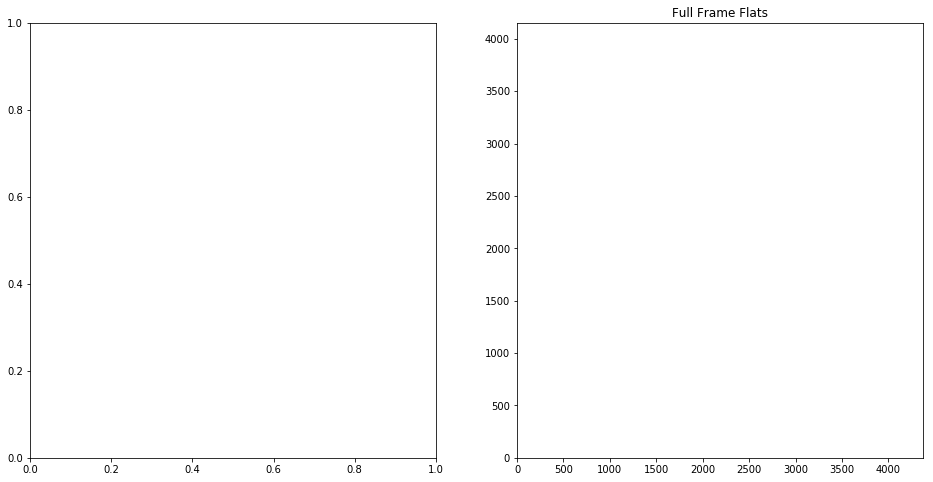

In [39]:
##################################################################################
#####        Below: Plotting for sanity check ----                           #####
#####            if something doesn't look right, check your input locations #####
#####          (you can turn this off if you'd like, not the del commands)   #####
##################################################################################

levels_d=np.linspace(np.nanmin(dark_full[0,:,:]),np.nanmax(dark_full[0,:,:]),20)
levels_f=np.linspace(0,1.4,20)

fig,ax=plt.subplots(1,2,figsize=(16.,8.))
ax[0].contourf(dark_full[0,:,:],levels=levels_d,cmap=plt.cm.Greys_r)      
ax[0].set_title('Full Frame Darks')
if binn!=1:
    ax[1].contourf(binned_flat[:,:],levels=levels_f,cmap=plt.cm.Greys_r)
if binn==1:
    ax[1].contourf(flat_full[0,:,:],levels=levels_f,cmap=plt.cm.Greys_r)
ax[1].set_title('Full Frame Flats')

del dark_full
del flat_full

# --------------------------------------------------------------------------- 
# Creates Object Masks

(these are used to later only extract the parts of the data we want)

First: Objects are located using the flat_thres variable

Second: Vertical Chips are Stitched

Third: Horizontal Chips are Stitched

Fourth: Objects are Combined across Vertical Chips. 

 CHIP ALIGNMENT:
---------------------------------
|   6   |   5   |   8   |   7   |
---------------------------------
|   1   |   2   |   3   |   4   |
---------------------------------
 
------------------------------
 Working on chips 6 & 1
------------------------------
   -->>  DATA STITCHED


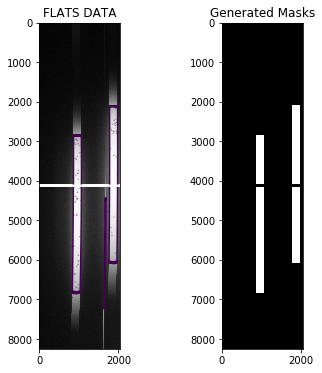

 
------------------------------
 Working on chips 5 & 2
------------------------------
   -->>  DATA STITCHED


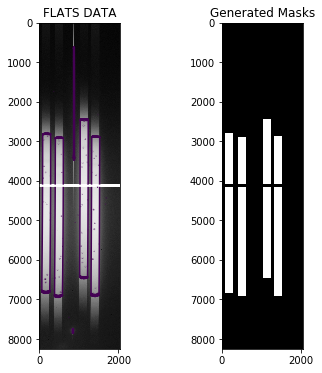

 
------------------------------
 Working on chips 8 & 3
------------------------------
   -->>  DATA STITCHED


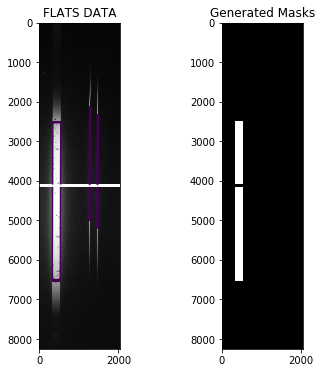

 
------------------------------
 Working on chips 7 & 4
------------------------------
   -->>  DATA STITCHED


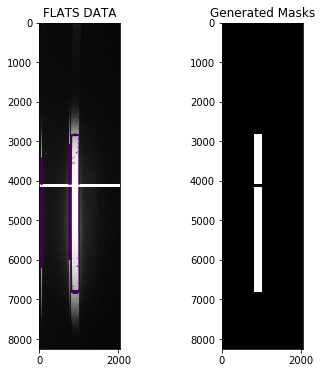

 -->> Combining Masks


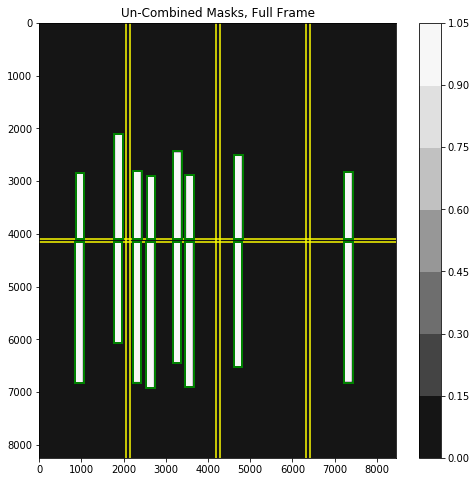

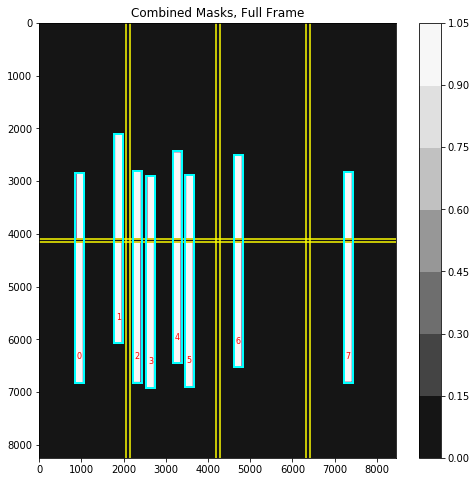

          (done)


In [53]:
## ------------------------------------------------------------- ##
## Masks are simply matrices of 1s and 0s                        ##
## ------------------------------------------------------------- ##

## user input needed:
#16 for wasp4
#34 for wasp52_1
#12 for wasp52_2
#6 for hats8_1
flat_root='ift0006c'         #root name of a slit flat image
flat_thres=5000.             #flat threshold: number of counts for 'edges' of masks.

#you may need to change the flat_thres value until you like the sizes of the extracted regions.

from FindMasks import FindMasks
from FindMasks import CombineMasks
#from FullFrame import FullFrame


masks=FindMasks(flat_path,flat_root,flat_thres,SAVEPATH,binn)
mask_full=FullFrame(1,masks,binn)
del masks

print' -->> Combining Masks'
mask_edges=CombineMasks(mask_full,SAVEPATH,binn)
print'          (done)'

del mask_edges

# NOTES:
# I need to find a way to ignore 0th order boxes. These can be trimmed later, for now
# this will be updated to be dependent on the median level of counts found

## last plot is sometimes small? don't know why... you can right click, open in new tab, and zoom in 

# --------------------------------------------------------------------------- 
# Define Objects: Label Target and Remove 0th-order


In [54]:
## ------------------------------------------------------------- ##
##  This rearranges masks so that the [0] element is the target  ##
##  zero-th order masks are also removed.                        ##
## ------------------------------------------------------------- ##

## using numbers output on combined mask image from cell above,define the following:
TAR=4                           #index for target
FIR=np.array([])     #indices for zeroth order masks. These will be deleted


################## don't change below  ################
mask_edges=np.load(SAVEPATH+'CombinedMasks.npz')['mask_edges']
masks_fin=np.empty([mask_edges.shape[0]-len(FIR),mask_edges.shape[1]])*0.0

masks_fin[0,:]=mask_edges[TAR,:]
j=1
for i in range(0,mask_edges.shape[0]):
    if not i in FIR and i!=TAR:
        masks_fin[j,:]=mask_edges[i,:]
        j+=1
        
np.savez_compressed(SAVEPATH+'FinalMasks.npz',masks=masks_fin)
del masks_fin

# --------------------------------------------------------------------------- 
# Extract 2D Spectra for each Object #
Dark is subtracted, Flat is divided out.

 -->> Loading Masks
          (done)
 -->> Loading Flats
              1.0
          (done)
 -->> Loading Darks
              590.486232528
          (done)
 -->> Loading HeaderData
               72
          (done)


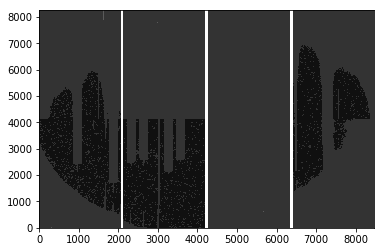

KeyboardInterrupt: 

In [2]:
from Extract2d import Extract2D

#extra=400                             #number of extra pixels to extract per side in y direction

Lflat=True                             #Logical switch to apply flats or not.

data=Extract2D(data_path,extray/binn,SAVEPATH,binn,Lflat)
del data

#output is a dictionary. Keys are formated as 'obj#', with 'obj0' being the target and 'obj1'+ being calibrators
#
#invalid value encountered in divide error - IGNORE. We are dividing full frame images which include NaNs for the gaps.

# --------------------------------------------------------------------------- 
# Cosmic Ray/Outlier Correction #

https://arxiv.org/pdf/1310.0083.pdf

(note, runs from exposure 3 through n_exp-2)


In [5]:
from Outlier import medcalc,Outlier

f=5                                                               #Cut-off (pixels over f std-devs from median)

n_obj=int(np.load(SAVEPATH+'FinalMasks.npz')['masks'].shape[0])
for i in range(0,n_obj):
    Outlier(i,f,SAVEPATH)
    

-----------------
  OBJECT #  0
-----------------
    --> Loading Data...
    --> Creating Diff Images...


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


         > EXPOSURE  10
         > EXPOSURE  20
         > EXPOSURE  30
         > EXPOSURE  40
         > EXPOSURE  50
         > EXPOSURE  60
         > EXPOSURE  70
         > EXPOSURE  80
         > EXPOSURE  90
         > EXPOSURE  100
         > EXPOSURE  110
         > EXPOSURE  120
         > EXPOSURE  130
         > EXPOSURE  140
         > EXPOSURE  150
         > EXPOSURE  160
    --> Calculating Medians...
    --> Identifying Outliers...
         > EXPOSURE  10
         > EXPOSURE  20
         > EXPOSURE  30
         > EXPOSURE  40
         > EXPOSURE  50
         > EXPOSURE  60
         > EXPOSURE  70
         > EXPOSURE  80
         > EXPOSURE  90
         > EXPOSURE  100
         > EXPOSURE  110
         > EXPOSURE  120
         > EXPOSURE  130
         > EXPOSURE  140
         > EXPOSURE  150
         > EXPOSURE  160
-----------------
  OBJECT #  1
-----------------
    --> Loading Data...
    --> Creating Diff Images...
         > EXPOSURE  10
         > EXPOSURE  20
 

# --------------------------------------------------------------------------- 
# Flatten 2D Spectra #

Fits a Background function and subtracts off.

Fits a gaussian to each line of the 2D Spectra to dectect the center.

The aperture is currently done as follows: Median aperture across lambda for each frame. Varies in time. Calcualted as 3*(median(FWHM)) of the guassian fit 

-----------------
  OBJECT #  0
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  130
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  140
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE


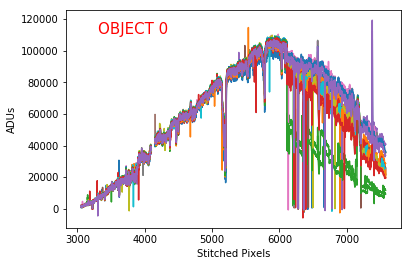

 
          time to run:  0:18:07.682448
-----------------
  OBJECT #  1
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


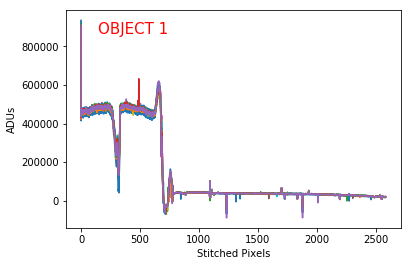

 
          time to run:  0:10:10.726551
-----------------
  OBJECT #  2
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


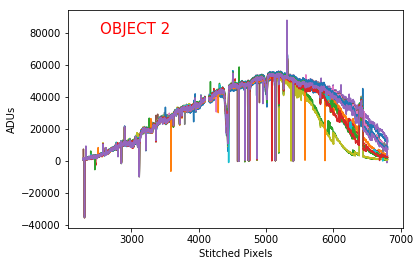

 
          time to run:  0:16:34.380246
-----------------
  OBJECT #  3
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


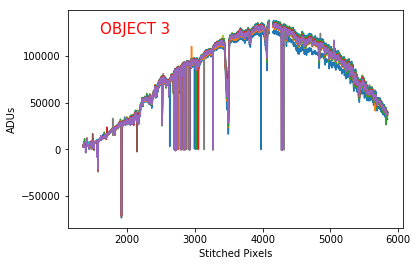

 
          time to run:  0:16:21.886972
-----------------
  OBJECT #  4
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


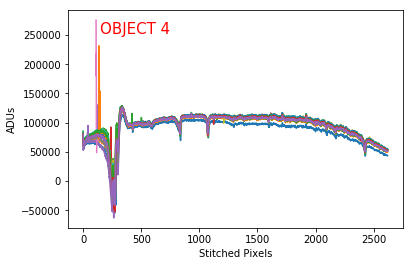

 
          time to run:  0:09:23.950042
-----------------
  OBJECT #  5
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


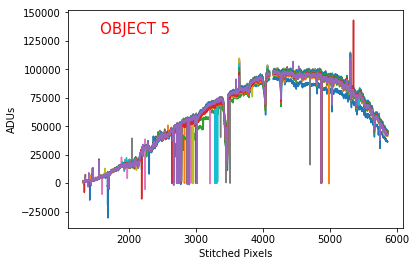

 
          time to run:  0:16:20.978634
-----------------
  OBJECT #  6
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


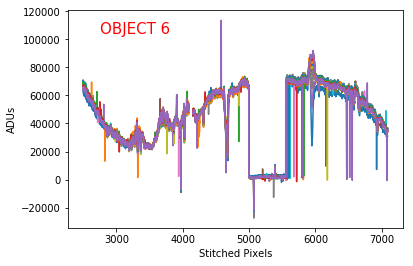

 
          time to run:  0:17:13.866558
-----------------
  OBJECT #  7
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


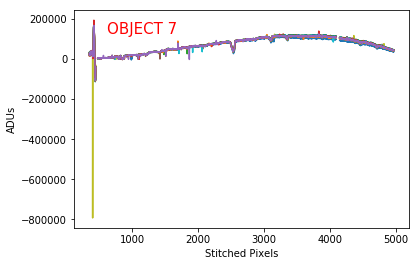

 
          time to run:  0:38:48.280063
-----------------
  OBJECT #  8
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


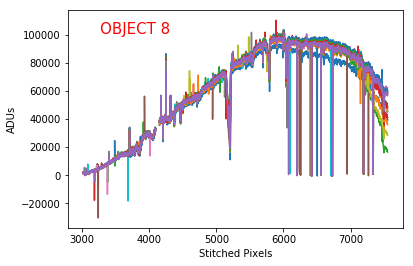

 
          time to run:  0:16:11.713817


In [2]:
from FlattenSpec import FlattenSpec

#extra=400

flat_spec=FlattenSpec(extray,SAVEPATH,False)

-----------------
  OBJECT #  0
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120
       -- FITTING GAUSSIANS
       -- SUM

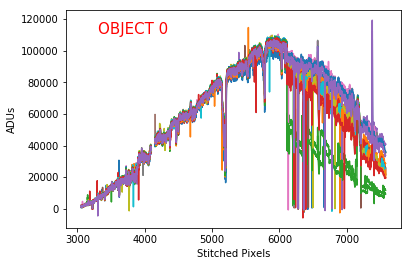

 
          time to run:  0:16:23.822216
-----------------
  OBJECT #  1
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


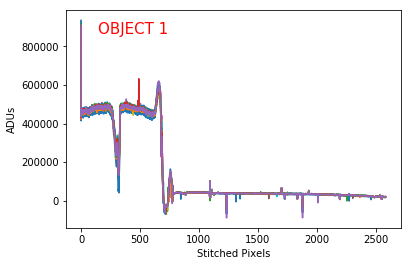

 
          time to run:  0:10:16.146783
-----------------
  OBJECT #  2
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


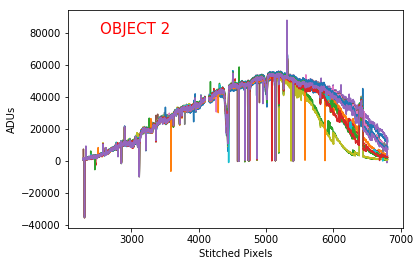

 
          time to run:  0:16:24.178978
-----------------
  OBJECT #  3
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


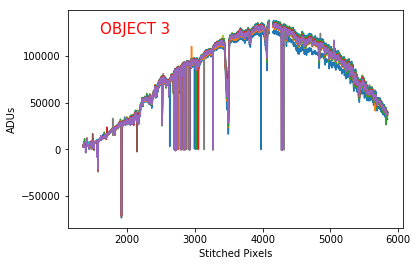

 
          time to run:  0:16:16.293785
-----------------
  OBJECT #  4
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


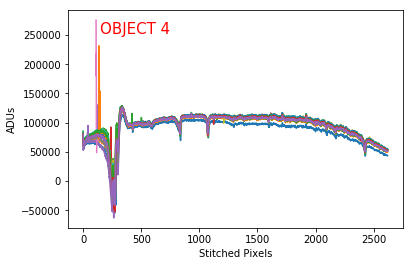

 
          time to run:  0:09:24.561670
-----------------
  OBJECT #  5
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


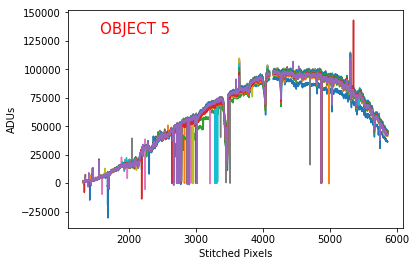

 
          time to run:  0:16:24.828909
-----------------
  OBJECT #  6
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


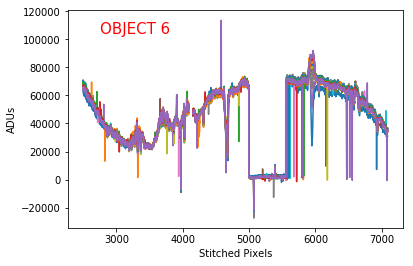

 
          time to run:  0:16:36.197722
-----------------
  OBJECT #  7
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE


KeyboardInterrupt: 

In [3]:
from FlattenSpec import FlattenSpec

#extra=400

flat_spec=FlattenSpec(extray,SAVEPATH,True)

# --------------------------------------------------------------------------- 
# Time Correltation and Apply Wavelength Calibration #
This accounts for shifts in the spectral direction by oversampling the spectra by your given factor and cross correlating in time to dectect shifts down to (1/factor) of a pixel.

After correlation, all spectra are shifted as necessary and wavelength calibration is applied.

--> TO DO: make size of convolving gaussian vary according to the extracted FWHM.

In [2]:
# to run this cell, you must have the wavelength solution text files
from AlignSpec import func_gaus
from AlignSpec import AlignSpec

osr=10
window=10

fwhm_gauss=5                    #Convolving gaussian FWHM in pixels

path0='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
wavelength_path0=path+'WaveSolution/'


corr=False
Aligned=AlignSpec(osr,window,fwhm_gauss,wavelength_path0,obj_name,SAVEPATH,extray,binn,corr)

del Aligned

-----------------
  OBJECT #  0
-----------------
 --Filtering...
    -->> TIME:  0


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


KeyboardInterrupt: 

-----------------
  OBJECT #  0
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 3274
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.0
    -->> TIME:  20     pixel shift:  0.0
    -->> TIME:  30     pixel shift:  0.0
    -->> TIME:  40     pixel shift:  0.0
    -->> TIME:  50     pixel shift:  0.0
    -->> TIME:  60     pixel shift:  0.0
    -->> TIME:  70     pixel shift:  0.0
    -->> TIME:  80     pixel shift:  0.0
    -->> TIME:  90     pixel shift:  0.0
    -->> TIME:  100     pixel shift:  0.0
    -->> TIME:  110     pixel shift:  -0.4


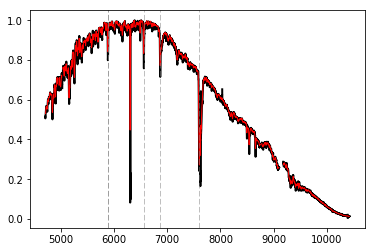

-----------------
  OBJECT #  1
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 4043
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.2
    -->> TIME:  20     pixel shift:  0.1
    -->> TIME:  30     pixel shift:  0.0
    -->> TIME:  40     pixel shift:  0.0
    -->> TIME:  50     pixel shift:  0.0
    -->> TIME:  60     pixel shift:  -1.6
    -->> TIME:  70     pixel shift:  0.0
    -->> TIME:  80     pixel shift:  0.0
    -->> TIME:  90     pixel shift:  0.0
    -->> TIME:  100     pixel shift:  0.0
    -->> TIME:  110     pixel shift:  1.0


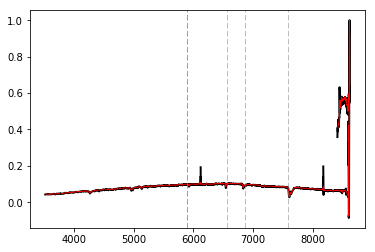

-----------------
  OBJECT #  2
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 2253
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  4.6
    -->> TIME:  20     pixel shift:  4.5
    -->> TIME:  30     pixel shift:  4.6
    -->> TIME:  40     pixel shift:  4.6
    -->> TIME:  50     pixel shift:  4.6
    -->> TIME:  60     pixel shift:  4.6
    -->> TIME:  70     pixel shift:  4.6
    -->> TIME:  80     pixel shift:  4.6
    -->> TIME:  90     pixel shift:  4.5
    -->> TIME:  100     pixel shift:  4.6
    -->> TIME:  110     pixel shift:  7.1


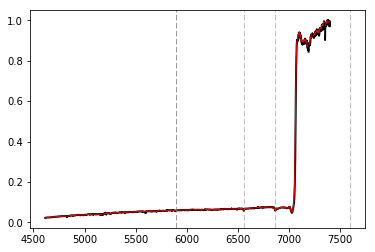

-----------------
  OBJECT #  3
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 7428
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.0
    -->> TIME:  20     pixel shift:  -0.6
    -->> TIME:  30     pixel shift:  -1.1
    -->> TIME:  40     pixel shift:  -1.9
    -->> TIME:  50     pixel shift:  -2.5
    -->> TIME:  60     pixel shift:  -2.4
    -->> TIME:  70     pixel shift:  -2.4
    -->> TIME:  80     pixel shift:  -2.6
    -->> TIME:  90     pixel shift:  -2.9
    -->> TIME:  100     pixel shift:  -2.5
    -->> TIME:  110     pixel shift:  -1.0


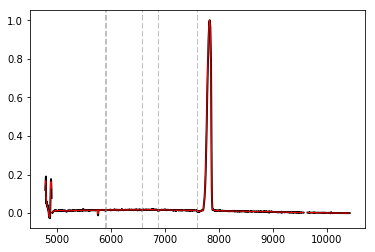

-----------------
  OBJECT #  4
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 986
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  3.0
    -->> TIME:  20     pixel shift:  2.7
    -->> TIME:  30     pixel shift:  2.5
    -->> TIME:  40     pixel shift:  2.2
    -->> TIME:  50     pixel shift:  2.1
    -->> TIME:  60     pixel shift:  2.1
    -->> TIME:  70     pixel shift:  2.1
    -->> TIME:  80     pixel shift:  2.1
    -->> TIME:  90     pixel shift:  2.0
    -->> TIME:  100     pixel shift:  2.4
    -->> TIME:  110     pixel shift:  5.6


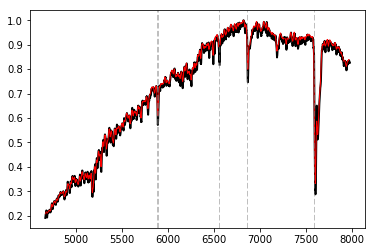

-----------------
  OBJECT #  5
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 4364
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.0
    -->> TIME:  20     pixel shift:  0.0
    -->> TIME:  30     pixel shift:  0.0
    -->> TIME:  40     pixel shift:  0.0
    -->> TIME:  50     pixel shift:  0.0
    -->> TIME:  60     pixel shift:  0.0
    -->> TIME:  70     pixel shift:  0.0
    -->> TIME:  80     pixel shift:  0.0
    -->> TIME:  90     pixel shift:  0.0
    -->> TIME:  100     pixel shift:  0.0
    -->> TIME:  110     pixel shift:  -6.2


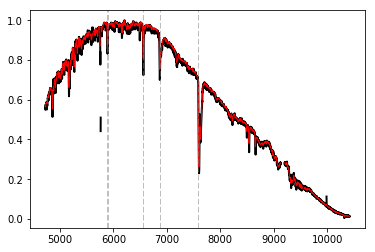

-----------------
  OBJECT #  6
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 1443
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  -13.1
    -->> TIME:  20     pixel shift:  -20.1
    -->> TIME:  30     pixel shift:  -20.0
    -->> TIME:  40     pixel shift:  -19.9
    -->> TIME:  50     pixel shift:  -20.1
    -->> TIME:  60     pixel shift:  -20.3
    -->> TIME:  70     pixel shift:  -20.4
    -->> TIME:  80     pixel shift:  -22.0
    -->> TIME:  90     pixel shift:  -20.3
    -->> TIME:  100     pixel shift:  -19.8
    -->> TIME:  110     pixel shift:  32.8
--------- BAD WAVELENGTH SOLUTION


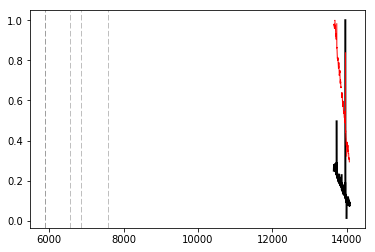

-----------------
  OBJECT #  7
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 3070
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  2.4
    -->> TIME:  20     pixel shift:  2.3
    -->> TIME:  30     pixel shift:  2.5
    -->> TIME:  40     pixel shift:  2.4
    -->> TIME:  50     pixel shift:  2.5
    -->> TIME:  60     pixel shift:  2.5
    -->> TIME:  70     pixel shift:  2.4
    -->> TIME:  80     pixel shift:  2.3
    -->> TIME:  90     pixel shift:  2.3
    -->> TIME:  100     pixel shift:  1.9
    -->> TIME:  110     pixel shift:  -1.2


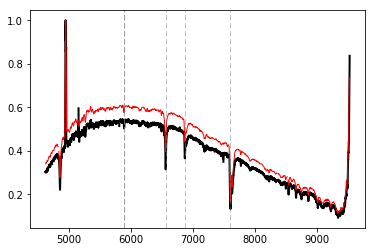

-----------------
  OBJECT #  8
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 1378
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  4.2
    -->> TIME:  20     pixel shift:  4.2
    -->> TIME:  30     pixel shift:  4.3
    -->> TIME:  40     pixel shift:  4.4
    -->> TIME:  50     pixel shift:  4.4
    -->> TIME:  60     pixel shift:  4.5
    -->> TIME:  70     pixel shift:  4.4
    -->> TIME:  80     pixel shift:  4.5
    -->> TIME:  90     pixel shift:  4.5
    -->> TIME:  100     pixel shift:  4.5
    -->> TIME:  110     pixel shift:  5.7


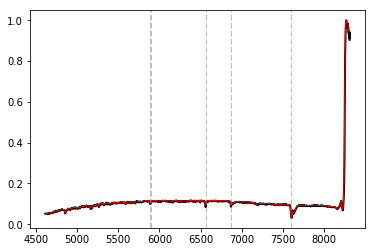

-----------------
  OBJECT #  9
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 3848
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  -0.3
    -->> TIME:  20     pixel shift:  -1.4
    -->> TIME:  30     pixel shift:  -1.7
    -->> TIME:  40     pixel shift:  -2.4
    -->> TIME:  50     pixel shift:  -2.5
    -->> TIME:  60     pixel shift:  -2.5
    -->> TIME:  70     pixel shift:  -2.7
    -->> TIME:  80     pixel shift:  -3.4
    -->> TIME:  90     pixel shift:  -3.9
    -->> TIME:  100     pixel shift:  -3.9
    -->> TIME:  110     pixel shift:  -6.5
--------- BAD WAVELENGTH SOLUTION


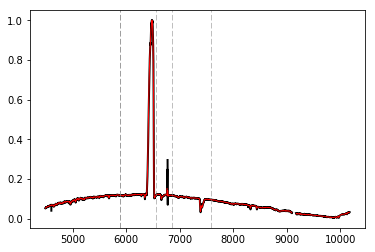

-----------------
  OBJECT #  10
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 7308
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.0
    -->> TIME:  20     pixel shift:  0.0
    -->> TIME:  30     pixel shift:  0.0
    -->> TIME:  40     pixel shift:  0.0
    -->> TIME:  50     pixel shift:  0.0
    -->> TIME:  60     pixel shift:  0.0
    -->> TIME:  70     pixel shift:  0.0
    -->> TIME:  80     pixel shift:  0.0
    -->> TIME:  90     pixel shift:  0.0
    -->> TIME:  100     pixel shift:  0.0
    -->> TIME:  110     pixel shift:  -10.7


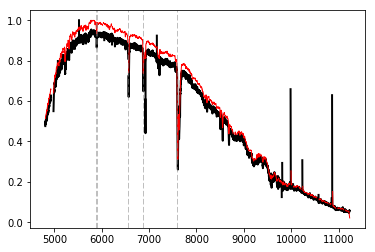

-----------------
  OBJECT #  11
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 4923
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  -1.0
    -->> TIME:  20     pixel shift:  -1.0
    -->> TIME:  30     pixel shift:  -1.0
    -->> TIME:  40     pixel shift:  -1.0
    -->> TIME:  50     pixel shift:  -1.0
    -->> TIME:  60     pixel shift:  -1.0
    -->> TIME:  70     pixel shift:  -1.0
    -->> TIME:  80     pixel shift:  -1.0
    -->> TIME:  90     pixel shift:  -1.0
    -->> TIME:  100     pixel shift:  -1.0
    -->> TIME:  110     pixel shift:  -1.0


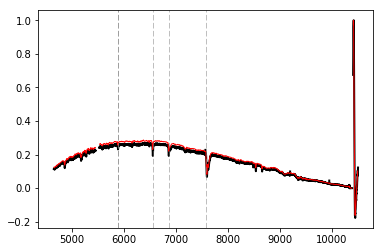

-----------------
  OBJECT #  12
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
       -->> 5900
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.0
    -->> TIME:  20     pixel shift:  0.0
    -->> TIME:  30     pixel shift:  0.0
    -->> TIME:  40     pixel shift:  0.0
    -->> TIME:  50     pixel shift:  0.0
    -->> TIME:  60     pixel shift:  0.0
    -->> TIME:  70     pixel shift:  0.0
    -->> TIME:  80     pixel shift:  0.0
    -->> TIME:  90     pixel shift:  0.0
    -->> TIME:  100     pixel shift:  0.0
    -->> TIME:  110     pixel shift:  -1.7


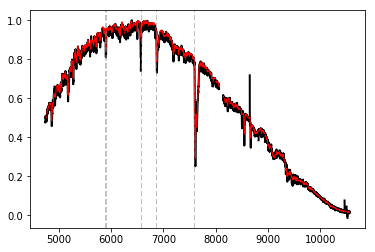

In [3]:
# to run this cell, you must have the wavelength solution text files
from AlignSpec import func_gaus
from AlignSpec import AlignSpec

osr=10
window=10

fwhm_gauss=5                    #Convolving gaussian FWHM in pixels

path0='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
wavelength_path0=path+'WaveSolution/'


corr=True
Aligned=AlignSpec(osr,window,fwhm_gauss,wavelength_path0,obj_name,SAVEPATH,extray,binn,corr)

del Aligned

# --------------------------------------------------------------------------- 
# Binning the Data

You can define the width of the bins here. 


8249
  -->> From Lambda= 4400  to Lambda= 8000
  -->> TOTAL OF  1 WAVELENGTH BINS
       Bin Centers:  [ 6200.]
       Bin Array:    [ 4400.  8000.]
       Bin Width:    3600
 
 >>>>>>>>>> OBJ:  0  <<<<<<<<<<
     -->> Summing up Wavelength Bins


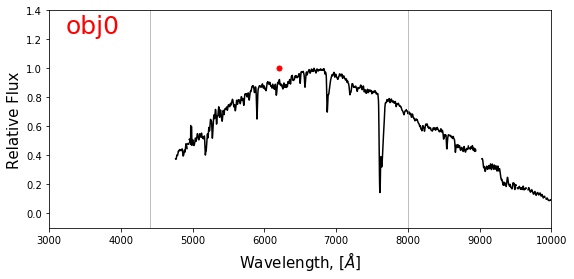

 
 >>>>>>>>>> OBJ:  1  <<<<<<<<<<
     -->> Summing up Wavelength Bins


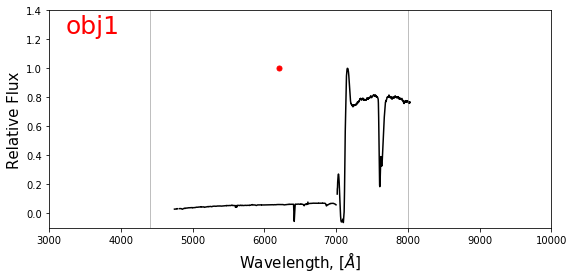

 
 >>>>>>>>>> OBJ:  2  <<<<<<<<<<
     -->> Summing up Wavelength Bins


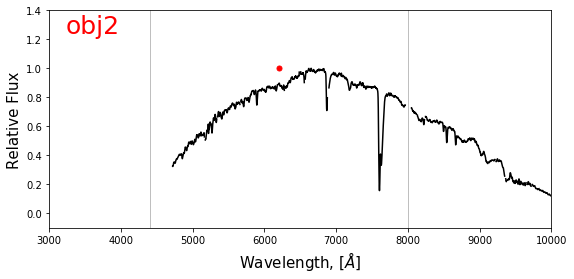

 
 >>>>>>>>>> OBJ:  3  <<<<<<<<<<
     -->> Summing up Wavelength Bins


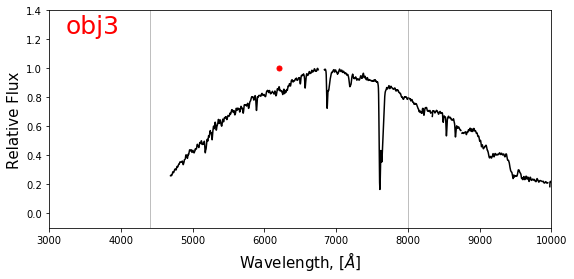

 
 >>>>>>>>>> OBJ:  4  <<<<<<<<<<
     -->> Summing up Wavelength Bins


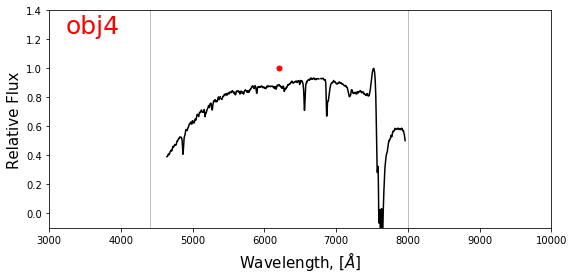

 
 >>>>>>>>>> OBJ:  5  <<<<<<<<<<
     -->> Summing up Wavelength Bins


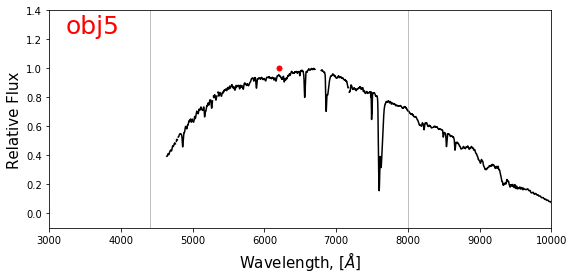

 
 >>>>>>>>>> OBJ:  6  <<<<<<<<<<
     -->> Summing up Wavelength Bins


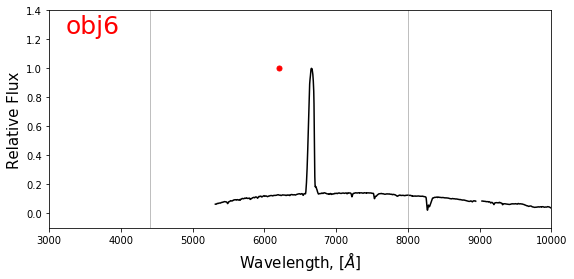

 
 >>>>>>>>>> OBJ:  7  <<<<<<<<<<
     -->> Summing up Wavelength Bins


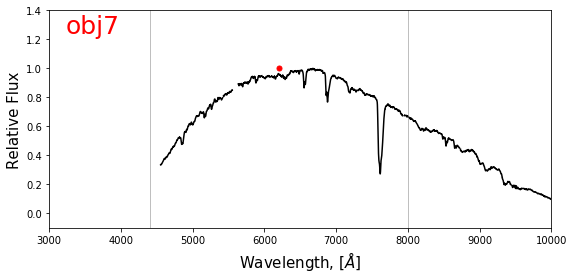

 
 >>>>>>>>>> OBJ:  8  <<<<<<<<<<
     -->> Summing up Wavelength Bins

In [ ]:
from Binning import BinWhite
from Binning import BinLam

start=4400
end=8000
width=50

corr=False
Test=BinWhite(SAVEPATH,midtime,start,end,corr)
Test2=BinLam(SAVEPATH,midtime,start,end,width,corr)

# --------------------------------------------------------------------------- 
# Generate Light Curves

The first cell takes as input the desired calibrators, as well as a check star (csn)
The second cell fits the baseline and removes it as a function of time (with specified order)

In [ ]:
from GenerateLC import LCgen_binns,LCgen_white


corr=False
width=50

Cals_ind=[2,3,5,8]  #Wasp52
csn=2

#Wasp4
#1,4,5,7,8,10,11,12
#USE: 5,

#HatP26b
#1,2,3,4,5,6,7
# X 1
#Cals_ind=[2,3,4,5,6]
#csn=2


white=LCgen_white(SAVEPATH,corr,Cals_ind,csn)
binns=LCgen_binns(SAVEPATH,width,corr,Cals_ind,csn)


In [ ]:
#Hats8 transit 1--- -0.05, 0.06
#W52 transit 1 --- -0.045, 0.035
#W52 transit 2 -- 
from BaselineFitting import blfit_binns,blfit_white

order=3         # polynomial order (in time)
avg=6           # number of points to average together
olow=0.98       # outlier - low end
ohigh=1.018      # outlier - high end
ybot=0.985       # ylim - low end (plot)
ytop=1.01       # ylim - high end (plot)

timein=-0.06
timeeg=0.06

#W52: -0.045, 0.035 
#W4: -0.05,0.045
#Hats8 -0.06,0.06

#corr=False
#width=200


white=blfit_white(SAVEPATH,order,avg,olow,ohigh,ybot,ytop,timein,timeeg,corr)
binns=blfit_binns(SAVEPATH,width,order,avg,olow,ohigh,ybot,ytop,timein,timeeg,corr)

# --------------------------------------------------------------------------- 
# Uses BATMAN to fit the light curves.

In [135]:
from LCfit import lcfit

width=200
corr=False
avg=False
nwalkers=250
burnin=200
nsteps=500
color=0   #0=white, 1=bins

white=lcfit(SAVEPATH,width,corr,avg,nwalkers,burnin,nsteps,0)
binns=lcfit(SAVEPATH,width,corr,avg,nwalkers,burnin,nsteps,1)


LCfit.py:65: SyntaxWarning: import * only allowed at module level
  def lnprior(SAVEPATH,theta,initial,color):
LCfit.py:84: SyntaxWarning: import * only allowed at module level
  def lnlike(SAVEPATH,theta,params,model,t,flux,err,color):
LCfit.py:149: SyntaxWarning: import * only allowed at module level
  def lcfit(SAVEPATH,width,corr,avg,nwalkers,burnin,nsteps,color):


['/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/ermay/Library/Jupyter/runtime/kernel-6b8fc841-1862-4bd5-9256-4602b11b47ed.json']
>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<
emcee: Exception while calling your likelihood function:
  params: [  1.73984623e-02   1.33823299e+00   1.28188456e-01   9.95154182e+01
   4.11441529e-01   1.83169483e-01]
  args: (array([  0.        ,   1.33823251,   0.15      ,  86.85      ,
         0.47466075,   0.23200093]), <batman.transitmodel.TransitParams object at 0x29de45ed0>, <batman.transitmodel.TransitModel instance at 0x11efd4320>, array([-0.15732125, -0.15288606, -0.14844394, -0.14400296, -0.13956894,
       -0.13513491, -0.13070667, -0.12625991, -0.12182472, -0.11738259,
       -0.11294278, -0.10850875, -0.10407356, -0.09963491, -0.09519856,
       -0.09076338, -0.08631894, -0.08188028, -0.07744509, -0.07302148,
       -0.06857125, -0.06413491, -0.05969972, -0.05525759, -0.0

Traceback (most recent call last):
  File "/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "LCfit.py", line 107, in lnprob
    prior=lnprior(SAVEPATH,theta,initial,color)
  File "LCfit.py", line 66, in lnprior
    sys.path.insert(0,SAVEPATH)
KeyboardInterrupt


KeyboardInterrupt: 

In [6]:
width=100
corr=False
avg=True

nwalkers=500
burnin=500
nsteps=5000

In [8]:
#####################################################                                                                                           
#####################################################                                                                                           
##        Fitting of lightcurves using BATMAN      ##                                                                                           
##  ---------------------------------------------  ##                                                                                           
##  reads in .npz files from Lightcurve_Script.py  ##                                                                                           
##     See README.txt in Magellan/pipeline         ##                                                                                           
#####################################################                                                                                           
#####################################################   

import numpy as np
np.seterr(all='ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import batman

import emcee
import corner

#import astropy
#from astropy.time import Time
#import pyfits                                                                                                                                  

import scipy
from scipy.interpolate import interp1d

from datetime import datetime
startTime1=datetime.now()

import sys
print (sys.argv)
 

sys.path.insert(0,SAVEPATH) 
from SystemCons import *

print per, rp, sma

#width=200


#################################
t=np.load(SAVEPATH+'Obs_times.npz')['times']
n_exp=len(t)
fulltime=np.load(SAVEPATH+'Obs_times.npz')['times']

if corr==True:
    if avg==True:
        t=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avt']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avf']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['avf']
        yerr_white=np.ones_like(lc_data_white)*np.nanmedian(np.load(SAVEPATH+'LCwhite_br_Corr.npz')['err_t'])
        yerr_binns=np.ones_like(lc_data_binns)*np.nanmedian(np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['err_t'],axis=0)
            
    else:
        t=np.load(SAVEPATH+'Obs_times.npz')['times']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['data']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['data']
        yerr_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['err_t']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['err_t']
else:
    if avg==True:
        t=np.load(SAVEPATH+'LCwhite_br.npz')['avt']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br.npz')['avf']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['avf']
        yerr_white=np.ones_like(lc_data_white)*np.nanmedian(np.load(SAVEPATH+'LCwhite_br.npz')['err_t'])
        yerr_binns=np.ones_like(lc_data_binns)*np.nanmedian(np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['err_t'],axis=0)
            
    else:   
        t=np.load(SAVEPATH+'Obs_times.npz')['times']
        n_exp=len(t)
    
        lc_data_white=np.load(SAVEPATH+'LCwhite_br.npz')['data']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['data']
        yerr_white=np.load(SAVEPATH+'LCwhite_br.npz')['err_t']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['err_t']
    
bin_ctr=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['bin_ctr']

####################################################                                                                                            
norm=matplotlib.colors.Normalize(vmin=np.min(bin_ctr),vmax=np.max(bin_ctr))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

####################################################                                                                                            
#              LIMB DARKENING FUNCION              #                                                                                            
####################################################                                                                                            
# U B V R I J H K                                                                                                                               

limb_dark='quadratic'

wave=[3640,4450,5510,6580,8060,12200]#,16300,21900]                                                                                             

q0_func=interp1d(wave,q0)
q1_func=interp1d(wave,q1)

####################################################                                                                                            
#              LIGHT CURVE FUNCTION                #                                                                                            
####################################################                                                                                            
def lc_func(t,t0,per,rp,a,inc,ecc,w,u,limb_dark):
    params=batman.TransitParams()
    params.t0=t0
    params.per=per
    params.rp=rp
    params.a=a
    params.inc=inc
    params.ecc=ecc
    params.w=w
    params.u=u
    params.limb_dark=limb_dark

    model=batman.TransitModel(params,t)
    return params, model

####################################################                                                                                            
#     Prior, Likelihood, Posterior Functions       #                                                                                            
####################################################                                                                                            
def loggaus(mean,sig,param):
    return -np.log(np.sqrt(2*np.pi*sig**2.))-((param-mean)**2.)/(2*sig**2.)

def lnprior(theta,color):
    if color==0:
        t0_f,per_f,rp_f,inc_f,c1_f,c2_f=theta
        if t0_f>t0dn and t0_f<t0up and rp_f>rpdn and rp_f<rpup and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return loggaus(per,per_e,per_f)+loggaus(inc,inc_e,inc_f)
        else:
            return -np.inf
    if color==1:
        rp_f,c1_f,c2_f=theta
        if rp_f<rpup and rp_f>rpdn and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return 0.0
        else:
            return -np.inf

def lnlike(theta,params,model,t,flux,err,color):
    if color==0:
        params.t0,params.per,params.rp,params.inc,c1_f,c2_f=theta
        params.u=[c1_f,c2_f]
        Ms_s=np.random.normal(loc=Ms,scale=Ms_e)
        Rs_s=np.random.normal(loc=Rs,scale=Rs_e)
        smacm=(((params.per*24.*60.*60.)**2.*Grav*Ms_s)/(4*np.pi**2.))**(1./3.)
        params.a=smacm/Rs_s
        fit=model.light_curve(params)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))
    if color==1:
        params.rp,c1_f,c2_f=theta
        params.u=[c1_f,c2_f]
        fit=model.light_curve(params)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))


def lnprob(theta,params,model,t,flux,err,color):
    prior=lnprior(theta,color)
    if not np.isfinite(prior):
        return -np.inf
    post=prior+lnlike(theta,params,model,t,flux,err,color)
    return post

####################################################                                                                                            
#     RUN MCMC CODE      #                                                                                            
####################################################   

def runmcmc(nwalkers,burnin,nsteps,pos0,params,model,time,data,error,color):
    sampler=emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2.0, args=(params,m,t,data,error,color))
    
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Running Burn-in...'))
                                                                                                                        
    time1=datetime.now()
    p0,test1,test2=sampler.run_mcmc(pos0,burnin)
    time2=datetime.now()
    Output.write('{0} {1} \n'.format('           Time to Run: ', time2-time1))
    sampler.reset()
                                                                                                                          

    Output.write('{0} \n'.format('     -->> Running Chain...'))
    Output.close()
    for i, result in enumerate(sampler.sample(p0,iterations=nsteps)):
        if (i+1)%(nsteps/10) ==0:
            Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
            Output.write('{0} {1} {2} \n'.format(("            {0:5.1%}".format(float(i+1) / nsteps)),'          ', datetime.now()))
            Output.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} {1} \n'.format('     -->> Mean Acceptance Fraction: ', np.mean(sampler.acceptance_fraction)))
    Output.close()
    
    samples=sampler.chain[:,:,:].reshape((-1,pos0.shape[1]))
    
    return samples

    

#####################
#nwalkers=500
#burnin=500
#nsteps=3000

Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','w')

color=0
if color==0:
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<'))
    print('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<')
    
    if np.nanmax(yerr_white)==0.0:
        yerr_white=np.ones_like(yerr_white)*10**-3.
    
    c1=q0_func(6000)
    c2=q1_func(6000)
    u=[c1,c2]
                                                                                                                          
    params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
    initial=np.array([t0,per,rp,inc,c1,c2])
    ndim=len(initial)
    
    Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
    Output.close()

    t0_arr=np.linspace(t0dn,t0up,10**6.)
    per_arr=np.linspace(per-5*per_e,per+5*per_e,10**6.)
    rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
    inc_arr=np.linspace(inc-5*inc_e,inc+5*inc_e,10**6.)
    c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
    c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

    pos0=np.empty([nwalkers,ndim])
    for i in range(nwalkers):
        pos0[i,:]=np.array([np.random.choice(t0_arr),np.random.choice(per_arr),np.random.choice(rp_arr),np.random.choice(inc_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
    runwhite=runmcmc(nwalkers,burnin,nsteps,pos0,params,m,t,lc_data_white,yerr_white,color)
    
    t0o,pero,rpo,inco,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runwhite, [16, 50, 84], axis=0)))
    t0,per,rp,inc,c1,c2=t0o[0],pero[0],rpo[0],inco[0],c1o[0],c2o[0]
    u=[c1,c2]
    sma=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    sma=sma/Rs

    params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    paramsp,mp=lc_func(fulltime,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        
    fitlightcurve=m.light_curve(params)
    fitlightcurvep=mp.light_curve(paramsp)
    
    residuals=(fitlightcurve-lc_data_white)*10**6.
    chi2=np.nansum(np.abs(residuals/10**6.)**2.)

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Best Fit Params'))
    Output.write('{0} {1} {2} {3} \n'.format('          t0  : ', t0,  np.round(t0o[1],5),np.round(t0o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          per : ', per, np.round(pero[1],10),np.round(pero[2],10)))
    Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
    Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
    Output.write('{0} {1} {2} {3} \n'.format('          inc : ', inc, np.round(inco[1],5),np.round(inco[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
    Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
    Output.close()

    plt.figure()
#    plt.clf()                                                                                                                                  
    plt.plot(t,lc_data_white,'.',markersize=10,markeredgecolor='black',markerfacecolor='grey')
    plt.plot(fulltime,fitlightcurvep,'-',color='black')
    plt.ylim(0.96,1.01)
    plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
#    plt.figtext(0.55,0.60, str(int(bin_wav[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_wav[b]))                                         
    plt.figtext(0.55,0.80, 'White Light', fontsize=25,color='grey')
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_white.png')
    plt.close()

    t0min=np.max([t0dn,t0-5*t0o[2]])
    t0max=np.min([t0up,t0+5*t0o[1]])
    rpmin=np.max([rpdn,rp-5*rpo[2]])
    rpmax=np.min([rpup,rp+5*rpo[1]])
    
    plt.clf()
    corner.corner(runwhite,labels=['t0','per','rp','inc','c1','c2'],truths=[t0,per,rp,inc,c1,c2],range=([t0min,t0max],[per-5*pero[2],per+5*pero[1]],[rpmin,rpmax],[inc-5*inco[2],inc+5*inco[1]],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_white.png')
    plt.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format(' '))
    Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
    Output.write('{0}\n'.format(' '))
    Output.close()

    params=np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
    paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])

    np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_white.npz',results=runwhite,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurvep,lcfitz=fitlightcurve,residuals=residuals)
    
    
color=1

if color==1:
    for b in range(0,len(bin_ctr)):
        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0} {1} {2}\n'.format('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<'))
        print('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<')
#        Output.write('{0} {1} \n'.format(' -->> WAVLENGTH CENTER = ', bin_ctr[b]))

        if np.nanmax(yerr_binns[:,b])==0.0:
            hold=np.ones_like(yerr_binns[:,b])*10**-3.
            yerr_binns[:,b]=hold
    
        c1=q0_func(bin_ctr[b])
        c2=q1_func(bin_ctr[b])
        u=[c1,c2]
                                                                                                                          
        params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
        initial=np.array([rp,c1,c2])
        ndim=len(initial)
    
        Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
        Output.close()

        rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
        c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
        c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

        pos0=np.empty([nwalkers,ndim])
        for i in range(nwalkers):
            pos0[i,:]=np.array([np.random.choice(rp_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
        runlam=runmcmc(nwalkers,burnin,nsteps,pos0,params,m,t,lc_data_binns[:,b],yerr_binns[:,b],color)
    
        rpo,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runlam, [16, 50, 84], axis=0)))
        rp,c1,c2=rpo[0],c1o[0],c2o[0]
        u=[c1,c2]

        params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        paramsp,mp=lc_func(fulltime,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        
        fitlightcurve=m.light_curve(params)
        fitlightcurvep=mp.light_curve(paramsp)
        
        residuals=(fitlightcurve-lc_data_binns[:,b])*10**6.
        chi2=np.nansum(np.abs(residuals/10**6.)**2.)

        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0} \n'.format('     -->> Best Fit Params'))
        Output.write('{0} {1} \n'.format('          t0  : ', t0))#,  np.round(t0o[1],5),np.round(t0o[2],5)))                                        
        Output.write('{0} {1} \n'.format('          per : ', per))#, np.round(pero[1],5),np.round(pero[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
        Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
        Output.write('{0} {1} \n'.format('          inc : ', inc))#, np.round(inco[1],5),np.round(inco[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
        Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
        Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
        Output.close()

        plt.figure()
#    plt.clf()                                                                                                                                  
        plt.plot(t,lc_data_binns[:,b],'.',markersize=10,markeredgecolor='black',markerfacecolor=scal_m.to_rgba(bin_ctr[b]))
        plt.plot(fulltime,fitlightcurvep,'-',color='black')
        plt.ylim(0.96,1.01)
        plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
        plt.figtext(0.55,0.80, str(int(bin_ctr[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_ctr[b]))                                         
#        plt.figtext(0.55,0.60, 'White Light', fontsize=25,color='grey')
        plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        rpmin=np.max([rpdn,rp-5*rpo[2]])
        rpmax=np.min([rpup,rp+5*rpo[1]])
    
        plt.clf()
        corner.corner(runlam,labels=['rp','c1','c2'],truths=[rp,c1,c2],range=([rpmin,rpmax],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
        plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0}\n'.format(' '))
        Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
        Output.write('{0}\n'.format(' '))
        Output.close()

        params=np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
        paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])

        np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_'+str(int(bin_ctr[b]))+'.npz',results=runlam,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurvep,lcfitz=fitlightcurve,residuals=residuals)

['/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/ermay/Library/Jupyter/runtime/kernel-6b8fc841-1862-4bd5-9256-4602b11b47ed.json']
3.583893 0.081 9.24021952675
>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:234: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:235: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:236: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:237: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:238: DeprecationWarning: object of type <type 'float'>

('>>>>>>>>>> WAVELENGTH BIN: ', 4650.0, ' <<<<<<<<<<')


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:332: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:333: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:334: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


('>>>>>>>>>> WAVELENGTH BIN: ', 4750.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 4850.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 4950.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5050.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5150.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5250.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5350.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5450.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5550.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5650.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5750.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5850.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5950.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6050.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6150.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6250.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6350.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6450.0, ' <<<<<<<<<<')
('>>>>>>>>

In [3]:
import sys
sys.path.insert(0,SAVEPATH) 
from SystemCons import *

print per, rp, sma
print SAVEPATH

3.583893 0.081 9.24021952675
/Volumes/ermay_ext/Magellan/ut20170723/SaveData_Hats8/


64


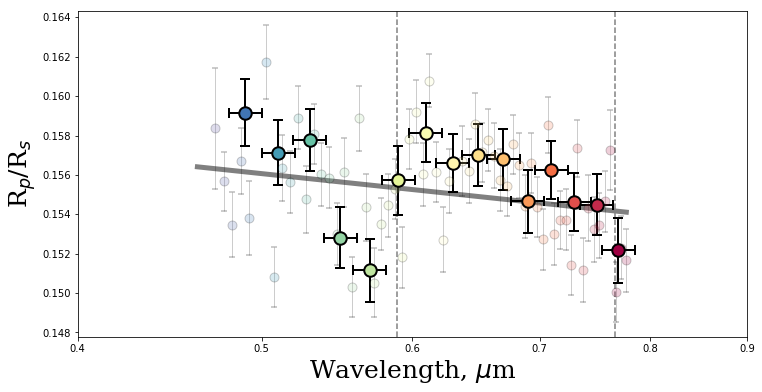

In [104]:
width=50

#mfile='HATS8b_1em1S.dat'
#model=(np.genfromtxt(SAVEPATH+mfile,usecols=[1],skip_header=2)/100)**(1./2.)
#mwave=np.genfromtxt(SAVEPATH+mfile,usecols=[0],skip_header=2)*10**10.


from matplotlib.font_manager import FontProperties
font0=FontProperties()
font=font0.copy()
font.set_family('serif')

import os

bin_ctr_200=np.load(SAVEPATH+'LC_bins_br_200.npz')['bin_ctr']
dt_e_p_200=np.nanmedian(np.load(SAVEPATH+'LC_bins_br_200.npz')['err_p'],axis=0)
dt_e_t_200=np.nanmedian(np.load(SAVEPATH+'LC_bins_br_200.npz')['err_t'],axis=0)
             
rp_200=np.empty([len(bin_ctr_200)])
rp_e_200=np.empty([len(bin_ctr_200)])
rs_e_200=np.empty([len(bin_ctr_200)])

bin_ctr=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['bin_ctr']
dt_e_p=np.nanmedian(np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['err_p'],axis=0)
dt_e_t=np.nanmedian(np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['err_t'],axis=0)
             
rp=np.empty([len(bin_ctr)])
rp_e=np.empty([len(bin_ctr)])
rs_e=np.empty([len(bin_ctr)])

norm=matplotlib.colors.Normalize(vmin=np.min(bin_ctr_200),vmax=np.max(bin_ctr_200))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

print len(bin_ctr)

b=0
for file in os.listdir(SAVEPATH+'Fits_'+str(int(width))+'/'):
    if file.endswith('.npz'):
        if b==len(bin_ctr):
            rbwhite=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['params'])[2]
        else:
            rp[b]=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['params'])[2]
            rp_e[b]=np.nanmedian((np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['paramserr'])[2])
            rs_e[b]=np.abs(np.nanmedian(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['residuals']))*10**-6
            b+=1
            
b=0
for file in os.listdir(SAVEPATH+'Fits_200/'):
    if file.endswith('.npz'):
        if b==len(bin_ctr_200):
            rbwhite_200=(np.load(SAVEPATH+'Fits_200/'+file)['params'])[2]
        else:
            rp_200[b]=(np.load(SAVEPATH+'Fits_200/'+file)['params'])[2]
            rp_e_200[b]=np.nanmedian((np.load(SAVEPATH+'Fits_200/'+file)['paramserr'])[2])
            rs_e_200[b]=np.abs(np.nanmedian(np.load(SAVEPATH+'Fits_200/'+file)['residuals']))*10**-6
            b+=1
            
owave=np.logspace(4000,9000,1000)

wavelog=np.log(bin_ctr)
test=np.polyfit(wavelog,rp,1)
test=(np.poly1d(test))(wavelog)
#tests=(np.poly1d(test))(np.log(mwave))
            
            
plt.figure(figsize=(12,6)) 
#plt.figure(figsize=(8,10.5)) #full page size
#plt.figure(figsize=(8,5.25)) #half page size

plt.plot(wavelog,test,color='grey',linewidth=5.0)
#plt.plot(np.log(mwave),model+tests-0.085,color='grey',linewidth=5.0)
#plt.plot(np.log(mwave),model,color='dimgrey',linewidth=2.0,linestyle='--')
for b in range(0,len(bin_ctr)):
    if b==0 or b==1 or b==7 or b==34:# or b==3 or b==11 or b==17:
        continue
    plt.plot(np.log(bin_ctr[b]),rp[b],'.', markeredgewidth=1.0,markersize=18,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]),alpha=0.2,zorder=11)
    plt.errorbar(np.log(bin_ctr[b]),rp[b],yerr=(rp_e[b]+rs_e[b]+dt_e_t[b]),color='black',elinewidth=1.0,capsize=3.0,capthick=2.0,alpha=0.2,zorder=10)

for b in range(0,len(bin_ctr_200)):
    if b==0:# or b==1 or b==3 or b==11 or b==17:
        continue
    plt.plot(np.log(bin_ctr_200[b]),rp_200[b],'.', markeredgewidth=2.0,markersize=25,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr_200[b]),zorder=11)
    plt.errorbar(np.log(bin_ctr_200[b]),rp_200[b],yerr=(rp_e_200[b]+rs_e_200[b]+dt_e_t_200[b]),xerr=0.02,color='black',elinewidth=2.0,capsize=5.0,capthick=2.0,zorder=10)
plt.axvline(x=np.log(5890),linestyle='--',color='grey')
plt.axvline(x=np.log(7665),linestyle='--',color='grey')

plt.xticks(np.log([4000,5000,6000,7000,8000,9000]),['0.4','0.5','0.6','0.7','0.8','0.9'])
plt.xlim(np.log(4000),np.log(9000))
#plt.ylim(0.08,0.15)  #Hats8b
#plt.ylim(0.16,0.18)
#plt.figtext(0.20,0.45,'Solar Composition Atmosphere,',fontsize=15, fontproperties=font, color='dimgrey')
#plt.figtext(0.20,0.40,'Increased Scattering Properties',fontsize=15, fontproperties=font, color='dimgrey')
#plt.figtext(0.15,0.20,'Standard Scattering Properties',fontsize=15, fontproperties=font, color='dimgrey')
#plt.annotate('Na',xy=(np.log(5900),0.13),xytext=(np.log(6000),0.145),arrowprops=dict(facecolor='black', shrink=0.01,width=1.5),fontsize=12,fontproperties=font)
#plt.annotate('K',xy=(np.log(7700),0.125),xytext=(np.log(8000),0.135),arrowprops=dict(facecolor='black', shrink=0.01,width=1.5),fontsize=12,fontproperties=font)
plt.ylabel('R$_p$/R$_s$',fontsize=25,fontproperties=font)
plt.xlabel('Wavelength, $\mu$m',fontsize=25,fontproperties=font)
#plt.show()
plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/TSpec.pdf')        

In [117]:
print rp
print rp_e

[ 0.15949483  0.15954306  0.15694375  0.1612186   0.16254193  0.15875766
  0.16978811  0.17089049  0.16582143  0.16969894  0.16081915  0.15677936
  0.16080465  0.16815951  0.17127783  0.16324317]
[ 0.02706086  0.01415127  0.01353614  0.0122257   0.01187644  0.01267135
  0.01136422  0.01093413  0.01151341  0.01260789  0.01240517  0.01209345
  0.01197567  0.01083277  0.01253746  0.01287247]


16
[ 4600.  4800.  5000.  5200.  5400.  5600.  5800.  6000.  6200.  6400.
  6600.  6800.  7000.  7200.  7400.  7600.  7800.  8000.  8200.]


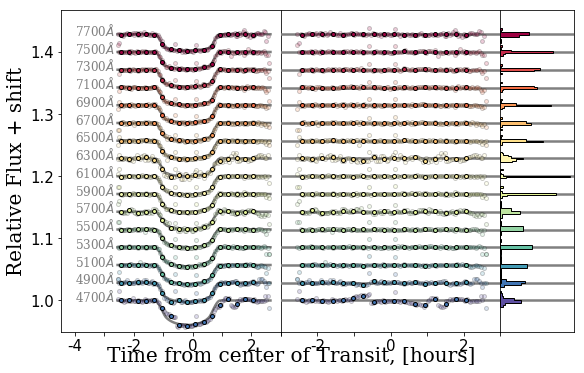

In [76]:
width=200
##############

from matplotlib.font_manager import FontProperties
font0=FontProperties()
font=font0.copy()
font.set_family('serif')

import matplotlib.gridspec as gridspec

import os
###############

lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['data']

t_z=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avt']
            
#lc_data_white_z=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avf']
lc_data_binns_z=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['avf']


bin_arr=np.load(SAVEPATH+'Binned_Data_'+str(int(width))+'.npz')['bins']
bin_ctr=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['bin_ctr']
n_bins=len(bin_ctr)

print n_bins

bin_arr=np.append(bin_arr,[bin_arr[-1]+width,bin_arr[-1]+2*width])
print bin_arr

###############
norm=matplotlib.colors.Normalize(vmin=np.min(bin_ctr),vmax=np.max(bin_ctr))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])
################

t=np.load(SAVEPATH+'Obs_times.npz')['times']
n_exp=len(t)

lc_fit=np.empty([n_exp,n_bins])
lc_fit_z=np.empty([len(t_z),n_bins])
lc_data=np.empty([n_exp,n_bins])

shift=np.linspace(0,n_bins/35., n_bins+1)

###############

b=0
for file in os.listdir(SAVEPATH+'Fits_'+str(int(width))+'/'):
    if file.endswith('.npz'):
        if b==len(bin_ctr):
            lcwhite=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['lightcurve_fit'])
        else:
            lc_fit[:,b]=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['lightcurve_fit'])
            lc_fit_z[:,b]=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['lcfitz'])
            b+=1


#plt.figure(figsize=(8.5,11))
#plt.figure(figsize=(10,7.5))
#plt.figure(figsize=(8,10.5)) #full page size
#plt.figure(figsize=(8,7.875))
plt.figure(figsize=(8,5.25)) #half page size

plt.gcf().subplots_adjust(bottom=0.1,top=0.95,left=0.1,right=0.99)
gs1=gridspec.GridSpec(1,7)
gs1.update(wspace=0.00,hspace=0.0)

ymin=0.95
ymax=1.01

p0=plt.subplot(gs1[:,:3])
for b in range(0,n_bins):
    #if b==0 or b==1:
    #    continue
    p0=plt.plot(24*t[:],lc_fit[:,b]+shift[b],'-',linewidth=2.5,color='grey',zorder=10)
    p0=plt.plot(24*t[:-1],lc_data_binns[:-1,b]+shift[b],'.',markeredgewidth=1.0,markersize=8,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]),zorder=11,alpha=0.2)
    p0=plt.plot(24*t_z[:-1],lc_data_binns_z[:-1,b]+shift[b],'.',markeredgewidth=1.0,markersize=8,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]+width),zorder=12)
    #p0=plt.errorbar(24*t[:-1],lc_data_binns[:-1,b]+shift[b],yerr=errs_l_t[:-1,b],ecolor=scal_m.to_rgba(bin_ctr[b]),elinewidth=0.5,alpha=0.7,fmt=None,zorder=11)
    p0=plt.xlim((t[0]-0.08)*24,(t[-1]+0.01)*24)
    p0=plt.ylim(ymin,ymax+shift[-1])
    p0=plt.ylabel('Relative Flux + shift',fontsize=20,fontproperties=font)
    p0=plt.yticks(fontsize=15)
    #p0=plt.xticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4],['','','-4','', '-2','','0','','2','','4'],fontsize=15)
    #p0=plt.xticks([-4,-3,-2,-1,0,1,2,3,4],['-4','', '-2','','0','','2','','4'],fontsize=15)
    p1=plt.xticks([-4,-3,-2,-1,0,1,2,3],['-4','','-2','','0','','2',''],fontsize=15)
    p0=plt.annotate(str(int(bin_ctr[b]))+'$\AA$',xy=(-4.0,1.0+shift[b]-0.002),ha='left',fontproperties=font,color='grey',fontsize=12)
    
residuals=lc_data_binns-lc_fit
residuals_z=lc_data_binns_z-lc_fit_z

p1=plt.subplot(gs1[:,3:6])
for b in range(0,n_bins):
    #if b==0 or b==1:
    #    continue
    p1=plt.axhline(y=np.nanmean((residuals[:-1,b])+shift[b]),color='grey',linewidth=2.5,zorder=10)
    p1=plt.plot(24*t[:-1],(residuals[:-1,b])+shift[b],'.',markeredgewidth=1.0,markersize=8,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]),zorder=11,alpha=0.2)
    p1=plt.plot(24*t_z[:-1],(residuals_z[:-1,b])+shift[b],'.',markeredgewidth=1.0,markersize=8,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]+width),zorder=12)
    #p1=plt.errorbar(24*t[:-1],(residuals[:-1,b])+shift[b],yerr=errs_l_t[:-1,b],ecolor=scal_m.to_rgba(bin_ctr[b]),elinewidth=0.5,alpha=0.7,fmt=None,zorder=11)
    p1=plt.yticks([],[])
    p1=plt.xticks([-3,-2,-1,0,1,2,3],['','-2','','0','','2',''],fontsize=15)
    p1=plt.ylim(ymin-1.0,ymax-1.0+shift[-1])

p2=plt.subplot(gs1[:,6])
for b in range(0,n_bins):
    #if b==0 or b==1:
    #    continue
    finite=residuals[np.isfinite(residuals[:,b]),b]
    p2=plt.axhline(y=np.nanmean((residuals[:-1,b])+shift[b]),color='grey',linewidth=2.5,zorder=10)
    p2=plt.hist((finite[:-1]+shift[b]),bins=7,orientation='horizontal',histtype='stepfilled',edgecolor='black',facecolor=scal_m.to_rgba(bin_ctr[b]),normed=True,zorder=11)
    p2=plt.ylim(ymin-1.0,ymax-1.0+shift[-1])
    p2=plt.yticks([],[])
    p2=plt.xticks([],[])
#plt.ylim(0.98,1.01+shift[-1])

plt.figtext(0.5,0.02,'Time from center of Transit, [hours]', fontsize=20, ha='center',fontproperties=font)
plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/all_lcs_err_pp.pdf')    

In [26]:
head=np.load(SAVEPATH+'HeaderData.npz')
airmass=head['airmass']
obs_times=head['obs_times']
ion_pump=head['ion_pump']
elc_noise=head['elc_noise']
ccd_temp=head['ccd_temp']
RA=head['RA']
Angle_e=head['Angle_e']
n_exp=head['n_exp']
stc_temp=head['stc_temp']
DEC=head['DEC']
Angle_o=head['Angle_o']

hrs=np.load(SAVEPATH+'Obs_times.npz')['times']

np.savez(SAVEPATH+'HeaderData_ML.npz',ne=n_exp,am=airmass,ot=time0,en=elc_noise,RA=RA,DC=DEC,ct=ccd_temp,st=stc_temp,ae=Angle_e,ao=Angle_o,ip=ion_pump)

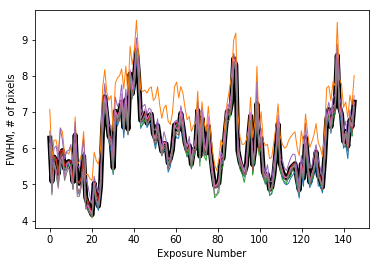

In [40]:
n_obj=9
n_exp=145

fwhm_a=np.empty([n_obj,n_exp])
bg_a=np.empty([n_obj,n_exp])

platescale=0.2  #arcseconds per pixel
for i in range(0,n_obj):
    params=np.load(SAVEPATH+'SpectraFitParams_'+str(int(i))+'.npz')
    fwhm=params['fwhm']
    xpix=params['x']
    bg=params['bg'][1]
    fwhm_av=params['fwhm_av']

    fwhm_a[i,:]=fwhm_av
    bg_a[i,:]=np.nanmedian(bg,axis=1)
    

fwhm_m=np.nanmedian(fwhm_a,axis=0)
bg_m=np.nanmedian(bg_a,axis=0)

#print fwhm_m
#print bg_m

plt.plot(np.linspace(0,n_exp,n_exp),fwhm_m,color='black',linewidth=5,zorder=0)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[0,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[1,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[2,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[3,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[4,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[5,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[6,:],linewidth=1)
#plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[7,:])
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[8,:],linewidth=1)
plt.ylabel('FWHM, # of pixels')
plt.xlabel('Exposure Number')
np.savez(SAVEPATH+'MedianFWHM.npz',fwhm=fwhm_m)

In [142]:
print errs_lcd_l_t[:,b]

[ 0.06188138  0.05605862  0.05852074  0.05865679  0.05827714  0.05777156
  0.05757962  0.05711648  0.05673258  0.05718997  0.05656756  0.05562569
  0.05636685  0.05569373  0.05514685  0.05600854  0.05563509  0.055763
  0.05491142  0.05481608  0.0544028   0.05391316  0.05330822  0.05305431
  0.05216543  0.05174717  0.05207655  0.0515003   0.05146683  0.05045672
  0.05104698  0.05066949  0.05096522  0.05098242  0.05029312  0.05118117
  0.05066683  0.05067776  0.05047189  0.05041241  0.0501543   0.04970376
  0.05005724  0.05015761  0.05032557  0.05005356  0.05014247  0.04995878
  0.0504389   0.05017348  0.04931016  0.05046851  0.05057645  0.05103996
  0.05027329  0.05204772  0.0518143   0.05210593  0.05217547  0.05215215
  0.0520535   0.05189675  0.05204079  0.05197475  0.05135046  0.05234536
  0.0518983   0.05235387  0.05186407  0.05224792  0.052801    0.05195641
  0.05199648  0.05180431  0.0519238   0.05182131  0.0519745   0.05190524
  0.05209023  0.05326169  0.05286266  0.05179399  0.0